<a href="https://colab.research.google.com/github/yashmehra028/so-fifa/blob/main/so_fifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
from bs4 import BeautifulSoup as bs
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import pandas as pd
import re
from threading import Thread
import collections

In [ ]:
def get_players_links(n_pages):
    offset = range(0,60*n_pages,60)
    player_links = []

    for offset_value in offset:
        r = requests.get(f'https://sofifa.com/players?offset={offset_value}')
        all_players_page = bs(r.content)
        tables = all_players_page.select('td.col-name')
        for table in tables:
            a_tag = table.find('a')
            url = a_tag['href']
            if 'player' in url and 'players' not in url:
                player_links.append('https://sofifa.com' + url)

    counter = collections.Counter(player_links)
    return [i[0] for i in counter.most_common()]


In [3]:
def get_player_link(table):
  a_tag = table.find('a')
  url = a_tag['href']
  if 'player' in url and 'players' not in url:
    final = 'https://sofifa.com' + url
    # print(final)
    return final

In [6]:
def player_links_crawler(offset_val):
  player_urls = []
  threads = []
  r = requests.get((f'https://sofifa.com/players?offset={offset_val}'))
  page_content = bs(r.content)
  tables = page_content.select('td.col-name')
  for table in tables:
    thread = Thread(target= lambda q, t: q.append(get_player_link(table)), args=(player_urls, table))
    thread.start()
    threads.append(thread)
  for t in threads:
    t.join()
  return player_urls

In [8]:
def get_player_links(n_pages):
  threads = []
  que = []
  for offset_value in range(0,60*n_pages,60):
    thread = Thread(target= lambda q, offset: q.extend(player_links_crawler(offset)), args=(que, offset_value))
    thread.start()
    threads.append(thread)
  for t in threads:
    t.join()
  que = list(filter(None, que))
  return que

In [13]:
# players = collections.Counter()
players = np.array(get_player_links(300))
players = np.unique(players)


In [15]:
len(players)

17915

In [1]:
def get_name(player_page):

    name_div = player_page.find('div',attrs={'class':'info'})
    return [('Name',name_div.find('h1').get_text())]

def get_section_box(player_page):

    info_list = []

    for initial_info in player_page.select('section'):
        text = initial_info.get_text()
    
    if 'M' in text:
        text = text.replace('M','')
    if 'K' in text:
        text = text.replace('K','')
    
    pattern = re.compile(r'[+-]\d{1,2}')
    if pattern.findall(text):
        for i in pattern.findall(text):
            text = text.replace(i,'').strip()

    
    pattern_num = re.compile(r'\d+[\.\d+]*')
    pattern_text = re.compile(r'[A-Za-z]+')
    
    num_list = pattern_num.findall(text)
    char_list = pattern_text.findall(text)
    char_list[0] += ' ' + char_list[1]
    char_list.pop(1)

    for i in range(len(num_list)):
        info_list.append((char_list[i],float(num_list[i])))

    return info_list

def get_skills(player_page):

    valid_fields = ['Attacking', 'Skill', 'Movement','Power', 'Mentality', 'Defending', 'Goalkeeping']

    info_list = []
    divs = [i for i in player_page.select('div.card')]

    valid_divs = []
    for i in divs:
        if i.select('h5'):
            if i.select('h5')[0].get_text() in valid_fields:
                valid_divs.append(i)

    
    for i in valid_divs:
        info = [j.get_text().strip() for j in i.select('li')]
        
        for j in info:
            pattern_num = re.compile(r'\d+')
            pattern_text = re.compile(r'[A-Za-z]+\s*[A-Za-z]*')

            try:
                num = pattern_num.findall(j)[0]
                char = pattern_text.findall(j)[0]
                info_list.append((char,float(num)))
                
            except:
                pass


    return info_list

def get_height_weight(player_page):

    info_list = []

    all_text = player_page.find('div',attrs={'class':'meta ellipsis'}).get_text()
    nationality = player_page.find('div',attrs={'class':'meta ellipsis'}).find('a')['title']
    info_list.append(('Nationality',nationality))

    body_measures = ['Age','Height','Weight']

    pattern = re.compile(r'\d+[c|k|y]')
    values = pattern.findall(all_text)

    for i in range(len(values)):
        info_list.append((body_measures[i],float(values[i][:len(values[i])-1])))

    return info_list


def get_player_info(player_link):
    r = requests.get(player_link)
    player_page = bs(r.content)
    threads = []
    info_list = []
    threadA = Thread(target= lambda q , page: q.append(get_section_box(page)), args=(info_list, player_page))
    threadA.start()
    threads.append(threadA)
    threadB = Thread(target= lambda q , page: q.append(get_name(page)), args=(info_list, player_page))
    threadB.start()
    threads.append(threadB)
    threadC = Thread(target= lambda q , page: q.append(get_skills(page)), args=(info_list, player_page))
    threadC.start()
    threads.append(threadC)
    threadD = Thread(target= lambda q , page: q.append(get_height_weight(page)), args=(info_list, player_page))
    threadD.start()
    threads.append(threadD)
    for thread in threads:
      thread.join()
    # a = get_section_box(player_page)
    # b = get_name(player_page)
    # c = get_skills(player_page)
    # d = get_height_weight(player_page)

    return info_list

In [17]:
data = []
threads = []
i = 0
for link in players:
  i+=1
  if not (i % 180):
    print(i)
  thread = Thread(target= lambda q, link: q.append(get_player_info(link)), args=(data,link))
  thread.start()
  threads.append(thread)
for t in threads:
  t.join()

data
  # data.append(get_player_info(link))

180
360
540
720
900
1080
1260
1440
1620
1800
1980
2160
2340
2520
2700
2880
3060
3240
3420
3600
3780
3960
4140
4320
4500
4680
4860
5040
5220
5400
5580
5760
5940
6120
6300
6480
6660
6840
7020
7200
7380
7560
7740
7920
8100
8280
8460
8640
8820
9000
9180
9360
9540
9720
9900
10080
10260
10440
10620
10800
10980
11160
11340
11520
11700
11880
12060
12240
12420
12600
12780


Exception in thread Thread-144535:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-1-00384f4df855>", line 96, in <lambda>
    threadB = Thread(target= lambda q , page: q.append(get_name(page)), args=(info_list, player_page))
  File "<ipython-input-1-00384f4df855>", line 4, in get_name
    return [('Name',name_div.find('h1').get_text())]
AttributeError: 'NoneType' object has no attribute 'find'

Exception in thread Thread-144552:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-1-00384f4df855>", line 102, in <lambda>
    threadD = Thread(target= lambda q , page: q.append(get_height_weight(pa

12960
13140
13320
13500
13680
13860
14040
14220
14400
14580
14760
14940
15120
15300
15480
15660
15840
16020
16200
16380
16560
16740
16920
17100
17280
17460
17640
17820


[[None,
  [('Name', 'Claudemir Jerônimo Barretto')],
  [('Crossing', 59.0),
   ('Finishing', 76.0),
   ('Heading Accuracy', 70.0),
   ('Short Passing', 74.0),
   ('Volleys', 74.0),
   ('Dribbling', 78.0),
   ('Curve', 77.0),
   ('FK Accuracy', 66.0),
   ('Long Passing', 54.0),
   ('Ball Control', 77.0),
   ('Acceleration', 76.0),
   ('Sprint Speed', 74.0),
   ('Agility', 75.0),
   ('Reactions', 77.0),
   ('Balance', 64.0),
   ('Shot Power', 77.0),
   ('Jumping', 82.0),
   ('Stamina', 67.0),
   ('Strength', 66.0),
   ('Long Shots', 78.0),
   ('Aggression', 62.0),
   ('Interceptions', 37.0),
   ('Positioning', 76.0),
   ('Vision', 67.0),
   ('Penalties', 60.0),
   ('Marking', 25.0),
   ('Standing Tackle', 24.0),
   ('Sliding Tackle', 23.0),
   ('GK Diving', 5.0),
   ('GK Handling', 13.0),
   ('GK Kicking', 12.0),
   ('GK Positioning', 11.0),
   ('GK Reflexes', 14.0)],
  [('Nationality', 'Germany'),
   ('Age', 32.0),
   ('Height', 179.0),
   ('Weight', 74.0)]],
 [None,
  [('Name', 'Adrian

In [19]:
import pickle
with open('data.pkl', 'wb') as f:
   pickle.dump(data, f)

In [ ]:
def get_and_save_df(n_pages,name):
    player_links = get_players_links(n_pages)
    print(len(player_links))
    result = []
    i = 0
    for link in player_links:
        info_dict = {i[0]:i[1] for i in get_player_info(link)}
        result.append(info_dict)
        i += 1
        if i % 30 != 0:
            print(i, end = ' ')
        else:
            print(i)
    df = pd.DataFrame(result)

    if 'Marking' in df.columns:
        df.drop('Marking',1,inplace=True)

    df.dropna(inplace=True)

    df.to_csv(f'{name}.csv')
    return df

In [ ]:
df2 = get_and_save_df(1,'data2')

60
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Overall Rating       60 non-null     float64
 1   Potential            60 non-null     float64
 2   Value                60 non-null     float64
 3   Wage                 60 non-null     float64
 4   Name                 60 non-null     object 
 5   Crossing             60 non-null     float64
 6   Finishing            60 non-null     float64
 7   Heading Accuracy     60 non-null     float64
 8   Short Passing        60 non-null     float64
 9   Volleys              60 non-null     float64
 10  Dribbling            60 non-null     float64
 11  Curve                60 non-null     float64
 12  FK Accuracy          60 non-null     float64
 13  Long Passing         60 non-null     float64
 14  Ball Control         60 non-null     float64
 15  Acceleration         60 non-null     float

In [ ]:
df2.head()

,Overall Rating,Potential,Value,Wage,Name,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,...,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Nationality,Age,Height,Weight
0,69.0,72.0,1.9,6.0,Patrick Roberts,64.0,63.0,43.0,69.0,52.0,...,19.0,12.0,7.0,8.0,7.0,12.0,England,24.0,170.0,66.0
1,82.0,86.0,40.5,20.0,Noussair Mazraoui,78.0,69.0,65.0,82.0,56.0,...,80.0,12.0,7.0,13.0,12.0,12.0,Morocco,23.0,183.0,62.0
2,91.0,91.0,84.0,450.0,Karim Benzema,75.0,91.0,90.0,89.0,88.0,...,18.0,13.0,11.0,5.0,5.0,7.0,France,33.0,185.0,81.0
3,81.0,89.0,58.0,48.0,Rafael Alexandre Conceição Leão,69.0,78.0,63.0,75.0,72.0,...,21.0,10.0,12.0,15.0,11.0,9.0,Portugal,22.0,188.0,81.0
4,77.0,84.0,21.5,65.0,Conor Gallagher,65.0,74.0,49.0,78.0,58.0,...,58.0,7.0,6.0,15.0,9.0,9.0,England,21.0,182.0,74.0


chutiye itne desh hi nahi hai, 27 se kaam chalale



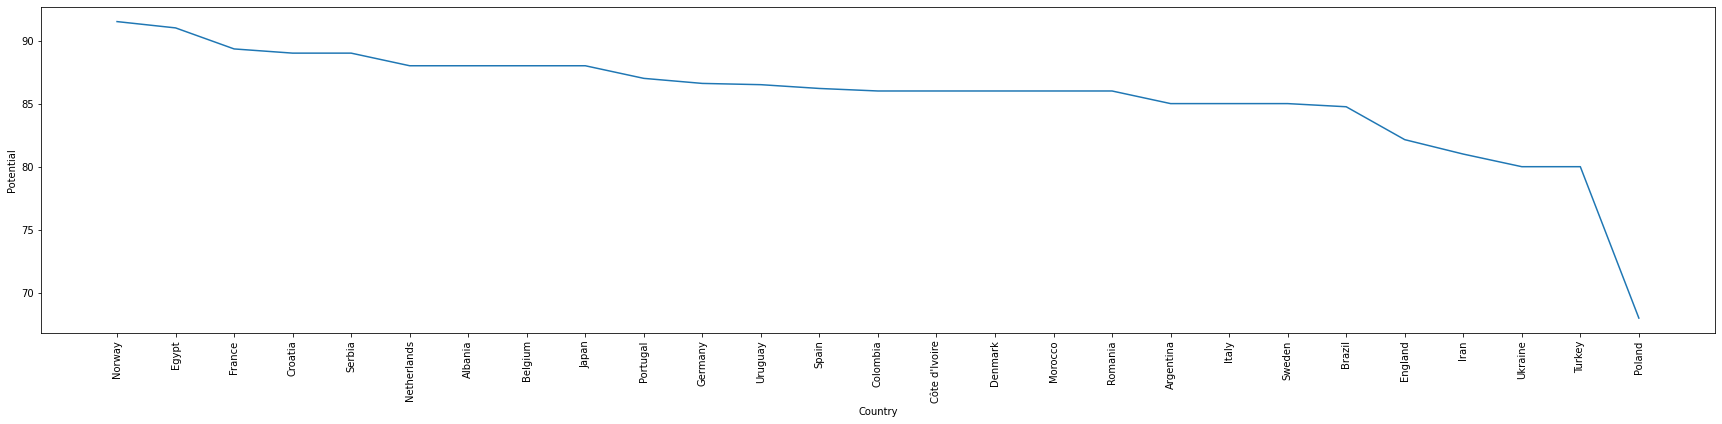

In [ ]:
def plot_average_attr_country(df,n_top_countries,attribute):

    nations_group = df.groupby('Nationality')
    temp = [(nation,df1['Name'].count(),df1[attribute].sum()/df1[attribute].count()) for nation, df1 in nations_group]
    temp.sort(key=lambda x:x[1],reverse=True)
    
    if n_top_countries <= len(temp):
        temp2 = [(temp[i][0],temp[i][2]) for i in range(n_top_countries)]
        temp2.sort(key=lambda x:x[1],reverse=True) 
        top_countries = [temp2[i][0] for i in range(n_top_countries)]
        attr_value = [temp2[i][1] for i in range(n_top_countries)]
        plt.figure(figsize=(30,6))
        plt.xticks(rotation = 90)
        plt.plot(top_countries,attr_value)
        plt.xlabel(f'Country')
        plt.ylabel(f'{attribute}')
    
    else:
        print(f'chutiye itne desh hi nahi hai, {len(temp)} se kaam chalale\n')
        n_top_countries = len(temp)
        temp2 = [(temp[i][0],temp[i][2]) for i in range(n_top_countries)]
        temp2.sort(key=lambda x:x[1],reverse=True) 
        top_countries = [temp2[i][0] for i in range(n_top_countries)]
        attr_value = [temp2[i][1] for i in range(n_top_countries)]
        plt.figure(figsize=(30,6))
        plt.xticks(rotation = 90)
        plt.plot(top_countries,attr_value)
        plt.xlabel(f'Country')
        plt.ylabel(f'{attribute}')

plot_average_attr_country(df2,90,'Potential')

In [ ]:
# #imdb
# import requests
# from bs4 import BeautifulSoup as bs

# def get_movie_links(n_pages):

#     all_movie_links = []

#     url = 'https://www.imdb.com/search/title/?country_of_origin=IN&start=201&ref_=adv_nxt'
#     start_values = range(1,n_pages*50,50)
#     for start in start_values:
#         url = f'https://www.imdb.com/search/title/?country_of_origin=IN&start={start}&ref_=adv_nxt'
#         r = requests.get(url)
#         all_links_page = bs(r.content)
#         h3_tags = all_links_page.select('h3')
#         for tag in h3_tags:
#             try:
#                 movie_url = tag.find('a')['href']
#                 full_url = f'https://www.imdb.com{movie_url}?ref_=adv_li_tt'
#                 all_movie_links.append(full_url)
            
#             except:
#                 pass
        

#     return all_movie_links
# all_links = get_movie_links(30) 